In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

2024-04-24 09:38:57.821161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 09:38:57.821337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 09:38:58.008792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image directories
train_dir = '/kaggle/input/human-activity-image-data/har_structured/train'
test_dir = '/kaggle/input/human-activity-image-data/har_structured/test'

# Define ImageDataGenerators for training and testing datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
#     shear_range=0.2,
    horizontal_flip=True,
#     rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size and image size
batch_size = 32
image_size = (224, 224)  # Target image size

# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size=batch_size,
    class_mode='categorical'  # for multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = image_size,
    batch_size=batch_size,
    class_mode='categorical'  # for multi-class classification
)

Found 10710 images belonging to 15 classes.
Found 1890 images belonging to 15 classes.


(32, 15)
{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}


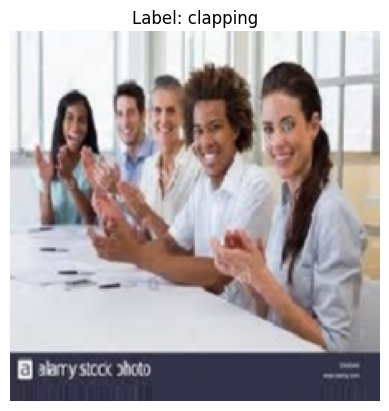

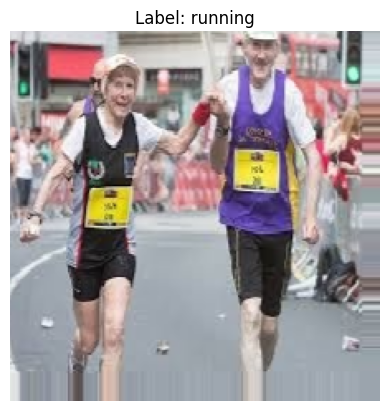

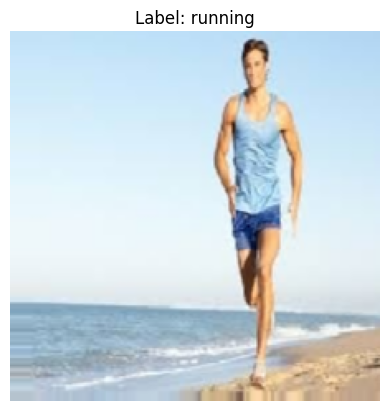

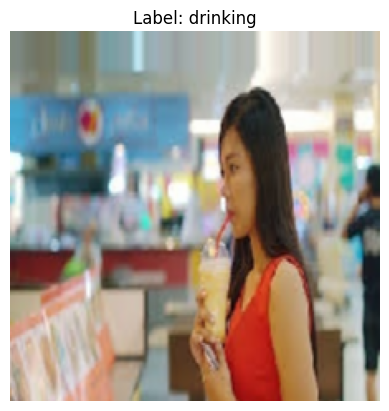

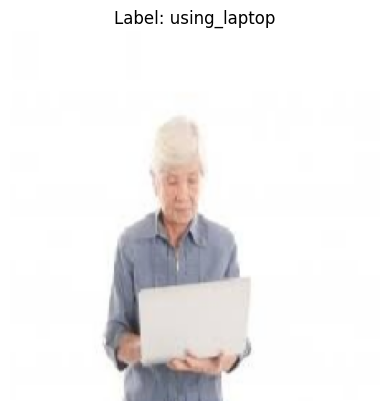

In [3]:
import os
import matplotlib.pyplot as plt

# Get a batch of data from the generator
images, labels = next(train_generator)

print(labels.shape)
# Get the class names from the directory names
class_names = list(train_generator.class_indices.keys())
print(train_generator.class_indices)
# Visualize a sample image and its inferred label
sample_index = 0  # Index of the sample image to visualize
for i in range(0, 5):
    plt.imshow(images[i])
    plt.title("Label: " + class_names[labels[i].argmax()])
    plt.axis("off")
    plt.show()

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.models import Model

def identity_block(X, filters):
    """
    Implementation of the identity block as defined in ResNet50
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization()(X)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, filters, s=2):
    """
    Implementation of the convolutional block as defined in ResNet50
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers
    s -- stride
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization()(X)
    
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape=(224, 224, 3), classes=15):
    """
    Implementation of the ResNet50 architecture
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    
    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape)
    X_input = RandomFlip(mode = 'horizontal', seed = 42)(X_input)
    X_input = RandomRotation(factor = 0.05, seed = 42)(X_input)
    X_input = RandomContrast(factor = 0.2, seed = 42)(X_input)
    
    # Zero-Padding
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 1
    X = convolutional_block(X, filters=[64, 64, 256], s=1)
    X = identity_block(X, [64, 64, 256])
    X = identity_block(X, [64, 64, 256])
    
    # Stage 2
    X = convolutional_block(X, filters=[128, 128, 512], s=2)
    X = identity_block(X, [128, 128, 512])
    X = identity_block(X, [128, 128, 512])
    X = identity_block(X, [128, 128, 512])
    
    # Stage 3
    X = convolutional_block(X, filters=[256, 256, 1024], s=2)
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    
    # Stage 4
    X = convolutional_block(X, filters=[512, 512, 2048], s=2)
    X = identity_block(X, [512, 512, 2048])
    X = identity_block(X, [512, 512, 2048])
    
    # AVGPOOL
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

# Create ResNet50 model
resnet50_model = ResNet50()
# Print model summary

In [5]:
resnet50_model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_3CLONE │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ keras_tensor_3CL… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[2][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ activation[2][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │      4,160 │ max_pooling2d[2]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_1[2][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 55, 55,    │     36,928 │ activation_1[2][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_2[2][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │     16,640 │ activation_2[2][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │     16,640 │ max_pooling2d[2]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_3[2][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_4[2][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 55, 55,    │          0 │ add[2][0]       

 Total params: 23,864,207 (91.03 MB)

 Trainable params: 23,811,087 (90.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [6]:
from tensorflow.keras.optimizers import Adam

# # Define distributed strategy
# strategy = tf.distribute.MirroredStrategy()

# # Create and compile model within the strategy's scope
# with strategy.scope():
#     # Define the momentum parameter (beta_1)
#     momentum_value = 0.9
#     # Create an Adam optimizer with momentum
#     optimizer = Adam(learning_rate=0.001, beta_1=momentum_value)
#     model = resnet50_model

#     model.compile(optimizer=optimizer,
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
model = resnet50_model
# momentum_value = 0.9
# optimizer = Adam
model.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# Train the model with distributed data
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


223/335 ━━━━━━━━━━━━━━━━━━━━ 23:31 13s/step - accuracy: 0.0797 - loss: 5.9936

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the model weights
model.save('/kaggle/working/my_model.keras')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/kaggle/working/my_model.keras')  # Replace 'your_model.h5' with the path to your saved model file

# Create an ImageDataGenerator for the test dataset
test_datagen = ImageDataGenerator(rescale=1.0/255)  # You may need to adjust other parameters based on how you preprocess your images
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust based on your input image size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
predictions = model.predict(test_generator)

# Get true labels
true_labels = test_generator.classes

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
class_names = test_generator.class_indices.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()